In [228]:
using QuantumToolbox
using SpecialFunctions
using CairoMakie
using JLD2
using FileIO


include("../src/utilities.jl")
include("../src/pulse.jl")
include("../src/hamiltonian.jl")
mkpath("figures/figures_thesis")

"figures/figures_thesis"

# Minimizer

In [249]:
f = load("data/PSO_2025-01-18T17:13:48.768.jld2")
minimizer = f["minimizer"]
min = f["min"]
println("Minimum value: ", min)


Minimum value: 0.0011366472626291048

┌ Warning: type Metaheuristics.State{Metaheuristics.xf_solution{Vector{Float64}}} does not exist in workspace; reconstructing
└ @ JLD2 /Users/yanislefur/.julia/packages/JLD2/NKGUi/src/data/reconstructing_datatypes.jl:575
┌ Warning: type Metaheuristics.xf_solution{Vector{Float64}} does not exist in workspace; reconstructing
└ @ JLD2 /Users/yanislefur/.julia/packages/JLD2/NKGUi/src/data/reconstructing_datatypes.jl:575
┌ Warning: type Metaheuristics.IterationLimit does not exist in workspace; reconstructing
└ @ JLD2 /Users/yanislefur/.julia/packages/JLD2/NKGUi/src/data/reconstructing_datatypes.jl:459


# Minimizer

In [248]:
omega_r = minimizer[1]
kappa = minimizer[2]
T = minimizer[3]
Amplitude_drive = minimizer[4]
omega_d = minimizer[5]

println("omega_r [GHz] = $omega_r, kappa [GHz] = $kappa , T [ns] = $T , Amplitude_drive [GHz] = $Amplitude_drive , omega_d [GHz] = $omega_d")


omega_r [GHz] = 43.9823, kappa [GHz] = 0.1676844436337354 , T [ns] = 43.08040198083685 , Amplitude_drive [GHz] = 0.5625007335956593 , omega_d [GHz] = 44.08540518659657


In [230]:
ec = 2*pi*0.315
ej = 51*ec
g = 2*pi*0.15
k_qubit = 2*pi*0.000008
omega_d = minimizer[5]

transmon = Transmon(Nt,Nx,ec,ej)
resonator = Resonator(Nr,minimizer[1],g)
Ht, nt, nt_tr, a = kron_system(transmon, resonator)

H = Ht + resonator.omega_r * a' * a - 1im * resonator.g *nt*(a - a') 
E,V = eigenstates(H , sparse=true, k=3, sigma=-transmon.ej - 0.5)
state0 = Qobj((V[1])) 
state1 = Qobj((V[2])) 
omega_r_dressed = E[3]/2pi

7.022855710864441 - 2.429101333480082e-15im

# States

In [231]:
f = load("data/simulation_full_2025-01-19T10:47:05.146.jld2")
states0  = f["states0"]
states1 = f["states1"]

f = load("data/simulation_rwa_2025-01-19T12:12:23.212.jld2")
states0_rwa  = f["states0"]
states1_rwa = f["states1"]


f = load("data/simulation_disp_2025-01-19T11:34:37.139.jld2")
states0_disp  = f["states0"]
states1_disp = f["states1"]
tlist = LinRange(0.0,minimizer[3],101)
Nr = 160
Nt = 5
a = kron(destroy(Nr),eye(Nt));
k_qubit = 2*pi*0.000008;

# Convergence test

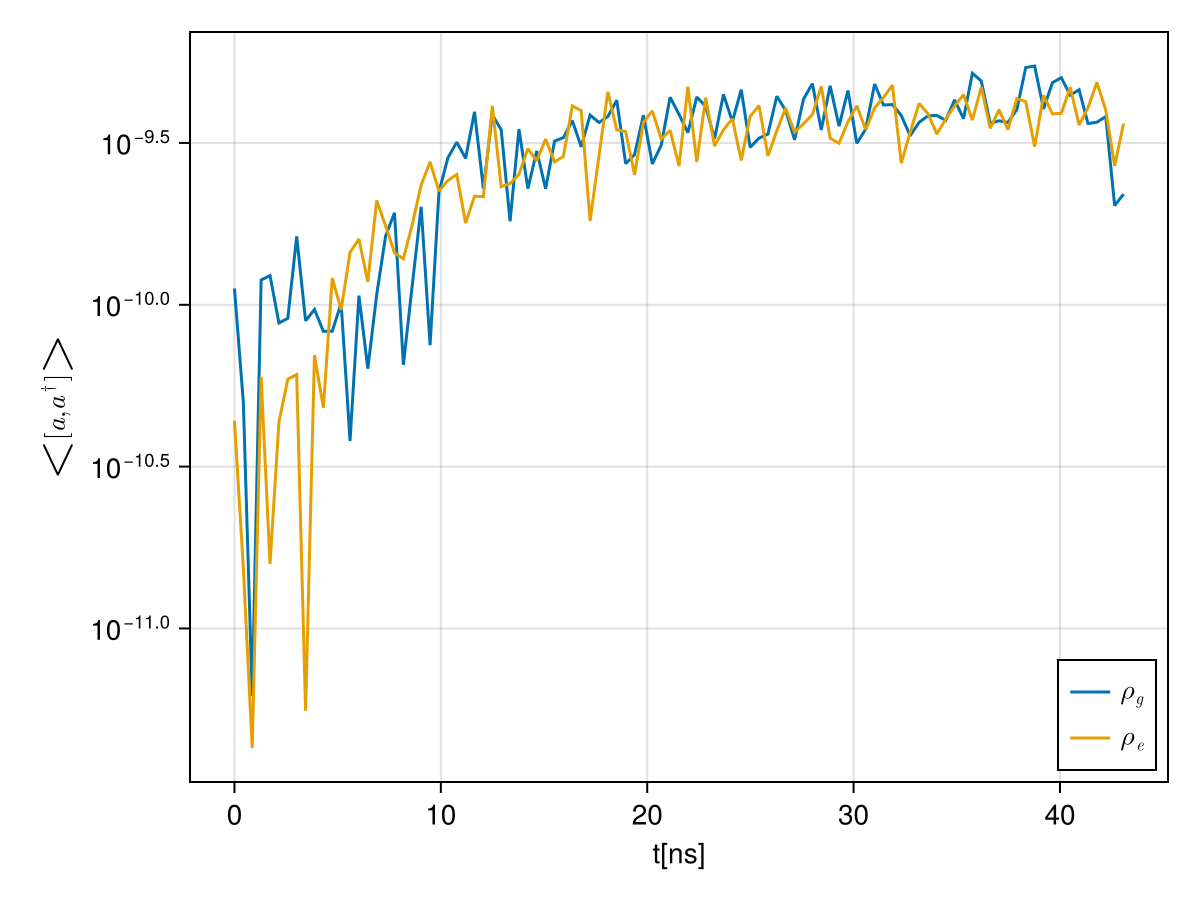

In [232]:
fig = Figure()
ax = Axis(fig[1,1],yscale = log10,xlabel = "t[ns]",ylabel = L"$\left<[a,a^\dagger]\right>$")
lines!(tlist,abs.((1.0).-real.(expect(commutator(a,a'),states0))),label = L"$\rho_g$")
lines!(tlist,abs.((1.0).-real.(expect(commutator(a,a'),states1))),label = L"$\rho_e$")
axislegend(position = :rb)
fig

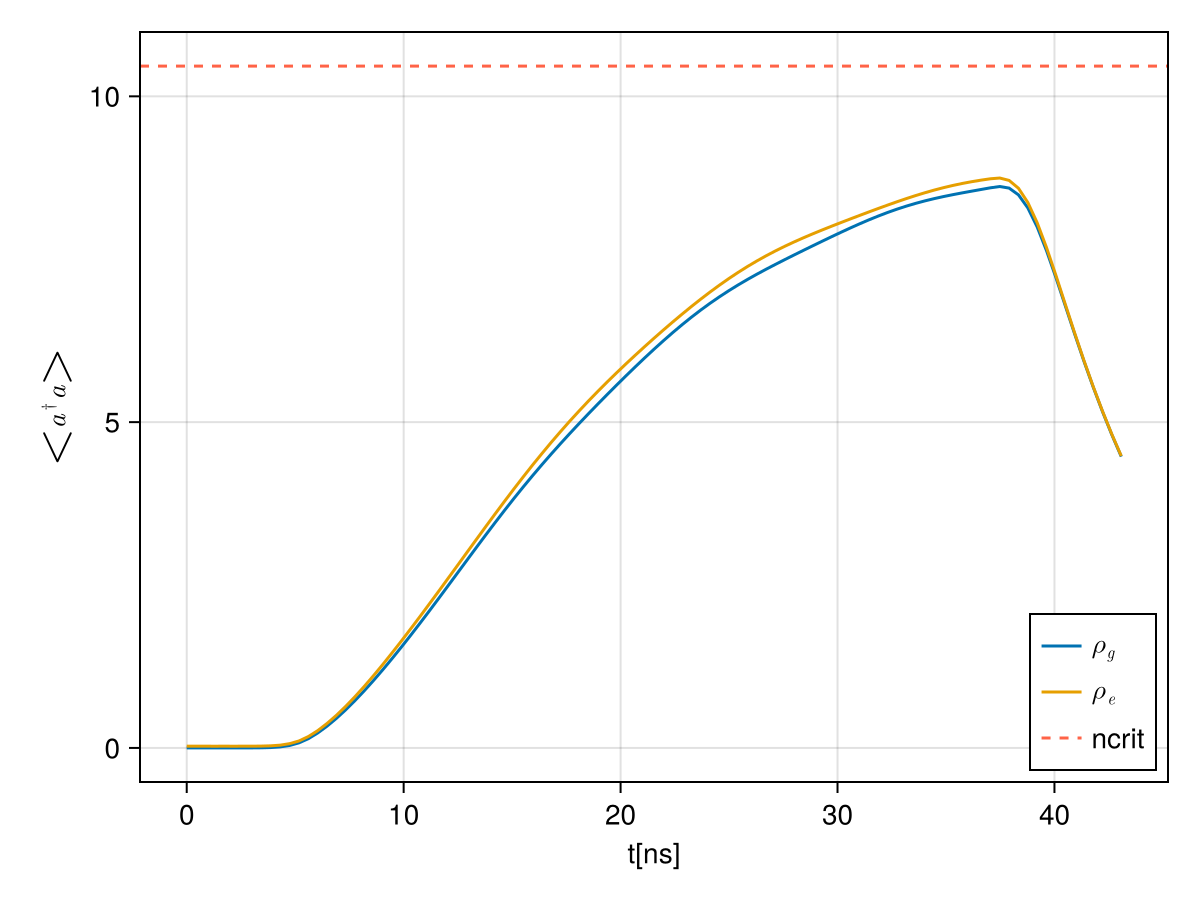

In [233]:


Nx = 1000
Nt = 5
ec = 2*pi*0.315
ej = 51*ec
g = 2*pi*0.15
transmon = Transmon(Nt,Nx,ec,ej)
ncrit = abs2(((transmon.E[2]-transmon.E[1])-minimizer[1])/(2*2*pi*0.15))
fig = Figure()
ax = Axis(fig[1,1],xlabel ="t[ns]",ylabel = L"$\left<a^\dagger{}a\right>$")
lines!(tlist,real.(expect(a'*a,states0)),label = L"$\rho_g$")
lines!(tlist,real.(expect(a'*a,states1)),label = L"$\rho_e$")
hlines!(ncrit,linestyle = :dash,color = :tomato,label = "ncrit")
axislegend(position = :rb)
fig

# Result full Hamiltonian

In [234]:
SNR = zeros(length(3:2:length(tlist)))
for (i,end_time) in enumerate(3:2:length(tlist))
    SNR[i]  = -opposite_SNR(states0[1:end_time],states1[1:end_time],a,tlist[1:end_time],1.0,minimizer[2])
end


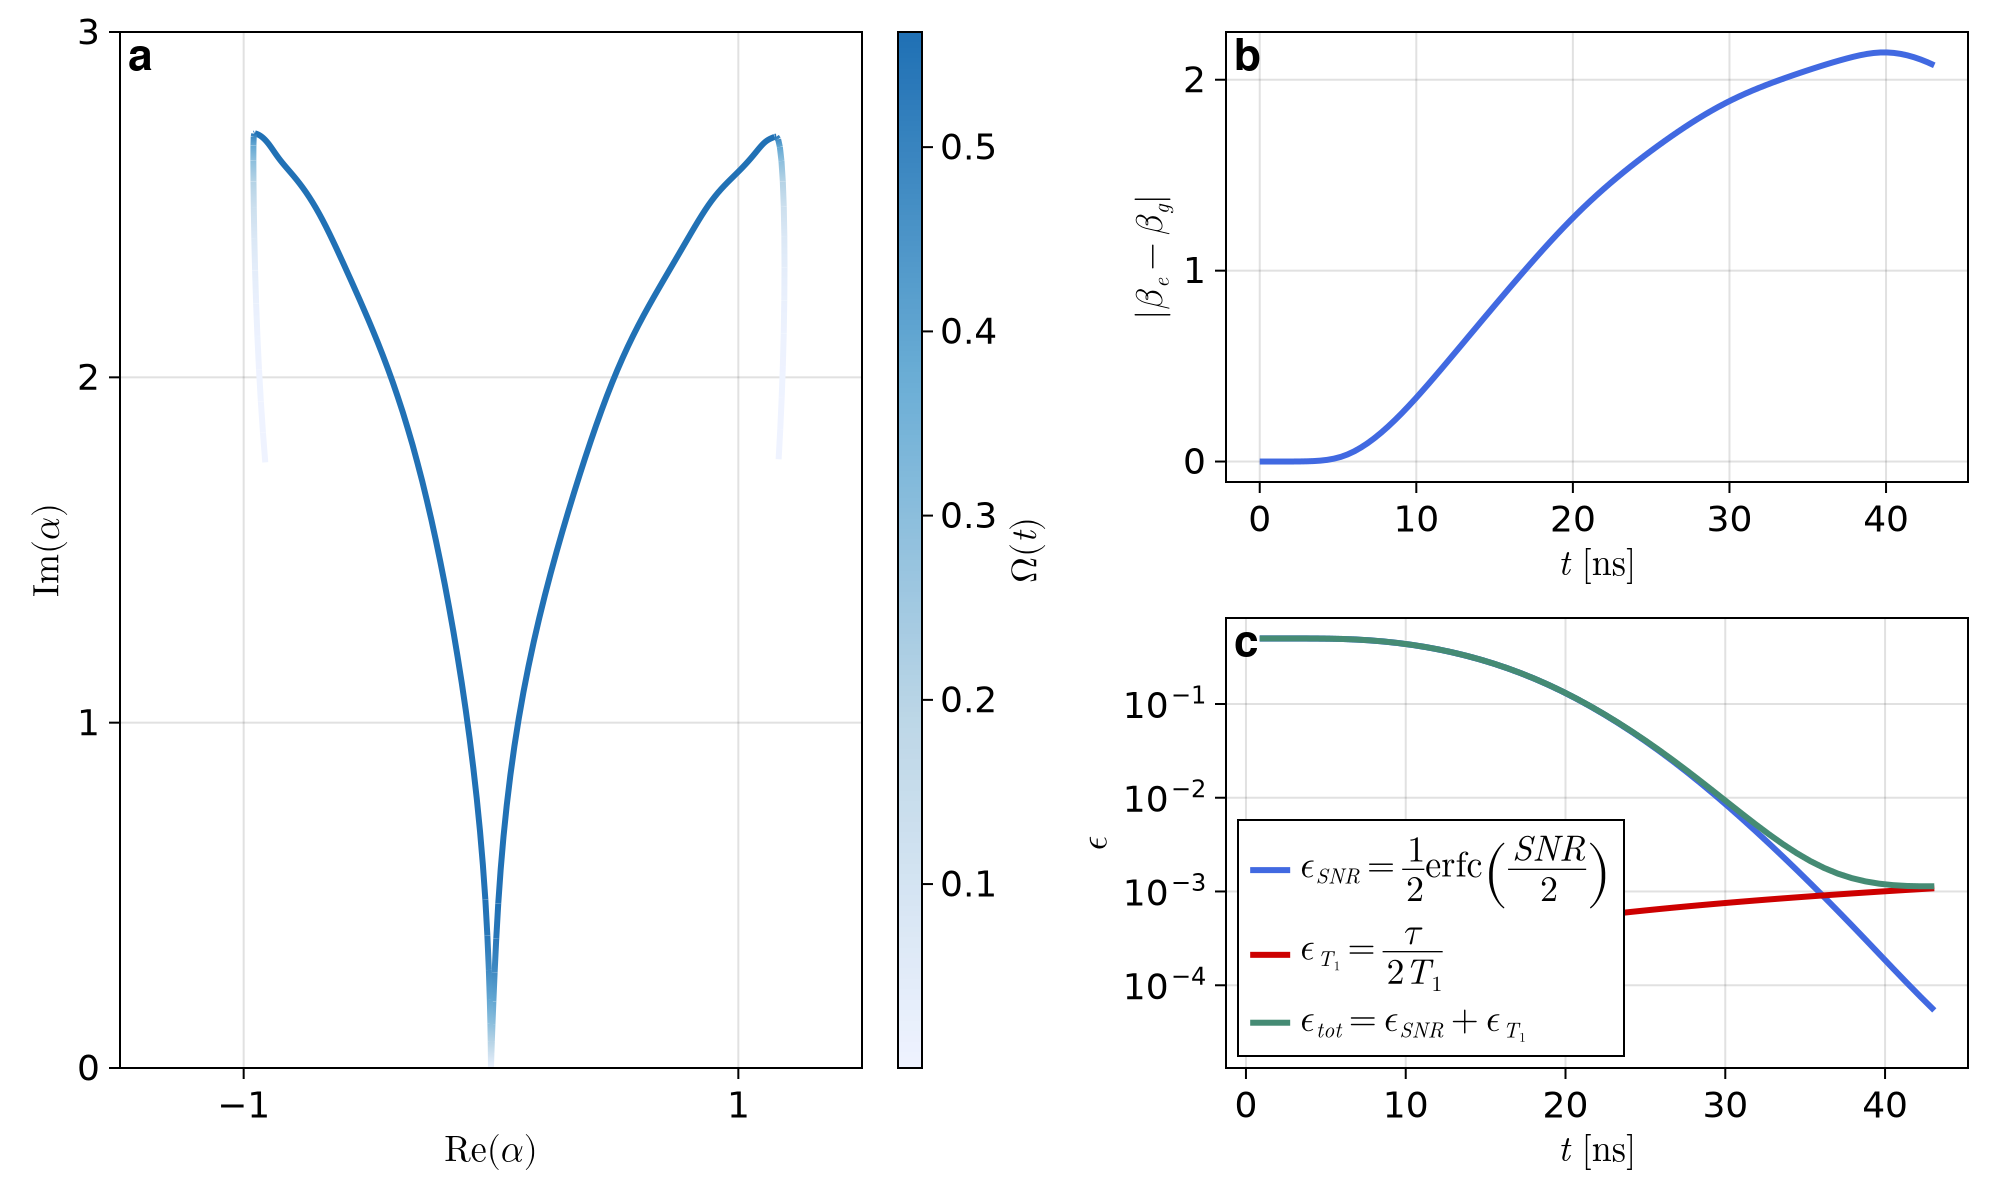

In [235]:
font_path = "/Users/yanislefur/Downloads/helvetica-255/Helvetica-Bold.ttf"
fig = Figure(size =(1000,600),fontsize = 18 ,fonts = (; regular = "Dejavu", weird = font_path))



ax1 = Axis(fig[1:2,1],xlabel = L"Re($\alpha$)",ylabel = L"Im($\alpha$)",xticks=[-1.0,1.0])
lines!(real.(expect(a,states0)),imag.(expect(a,states0)), color = square_gaussian.(tlist,tlist[end],1.5,4.0,minimizer[4]), colormap = :Blues_4,linewidth =3.0)
co = lines!(real.(expect(a,states1)),imag.(expect(a,states1)), color = square_gaussian.(tlist,tlist[end],1.5,4.0,minimizer[4]), colormap = :Blues_4,linewidth =3.0)
Colorbar(fig[1:2, 2], co,label = L"$\Omega(t)$")
xlims!(-1.5,1.5)
ylims!(0,3)
 


ax2 = Axis(fig[1,3],ylabel = L"|\beta_e-\beta_g|",xlabel =L"$t$ [ns]",yticks = [0.0,1.0,2.0])
lines!(tlist,abs.(expect(a,states1).-expect(a,states0)),linewidth = 3.0,color = :royalblue)


ax3 = Axis(fig[2,3],yscale = log10,ylabel = L"$\epsilon$",xlabel =L"$t$ [ns]")
lines!(tlist[3:2:end],0.5*erfc.(SNR/2),linewidth = 3.0,label = L"$\epsilon_{SNR} = \frac{1}{2}$erfc$\left(\frac{SNR}{2}\right)$",color = :royalblue)
lines!(tlist[3:2:end],k_qubit.*tlist[3:2:end]/2,linewidth = 3.0,label = L"$\epsilon_{T_1} = \frac{\tau}{2T_1}$",color = :red3)
lines!(tlist[3:2:end],(k_qubit/2).*tlist[3:2:end].+0.5*erfc.(SNR/2),linewidth = 3.0,label = L"$\epsilon_{tot} =\epsilon_{SNR}+\epsilon_{T_1} $",color = :aquamarine4)
axislegend(position = :lb)



text!(
        ax1, 0, 1,
        text = "a",
        align = (:left, :top),
        offset = (4, -2),
        space = :relative,
        fontsize = 22,
        font = :weird
)

text!(
        ax2, 0, 1,
        text = "b",
        align = (:left, :top),
        offset = (4, -2),
        space = :relative,
        fontsize = 22,
        font = :weird
)

text!(
        ax3, 0, 1,
        text = "c",
        align = (:left, :top),
        offset = (4, -2),
        space = :relative,
        fontsize = 22,
        font = :weird
)
save("figures/figures_thesis/minimzation_full_transmon.svg",format = "svg",fig)
fig


# Comparison

In [9]:

SNR_rwa = zeros(length(3:2:length(tlist)))
for (i,end_time) in enumerate(3:2:length(tlist))
    SNR_rwa[i]  = -opposite_SNR(states0_rwa[1:end_time],states1_rwa[1:end_time],a,tlist[1:end_time],1.0,minimizer[2])
end

SNR_disp = zeros(length(3:2:length(tlist)))
for (i,end_time) in enumerate(3:2:length(tlist))
    SNR_disp[i]  = -opposite_SNR(states0_disp[1:end_time],states1_disp[1:end_time],a,tlist[1:end_time],1.0,minimizer[2])
end




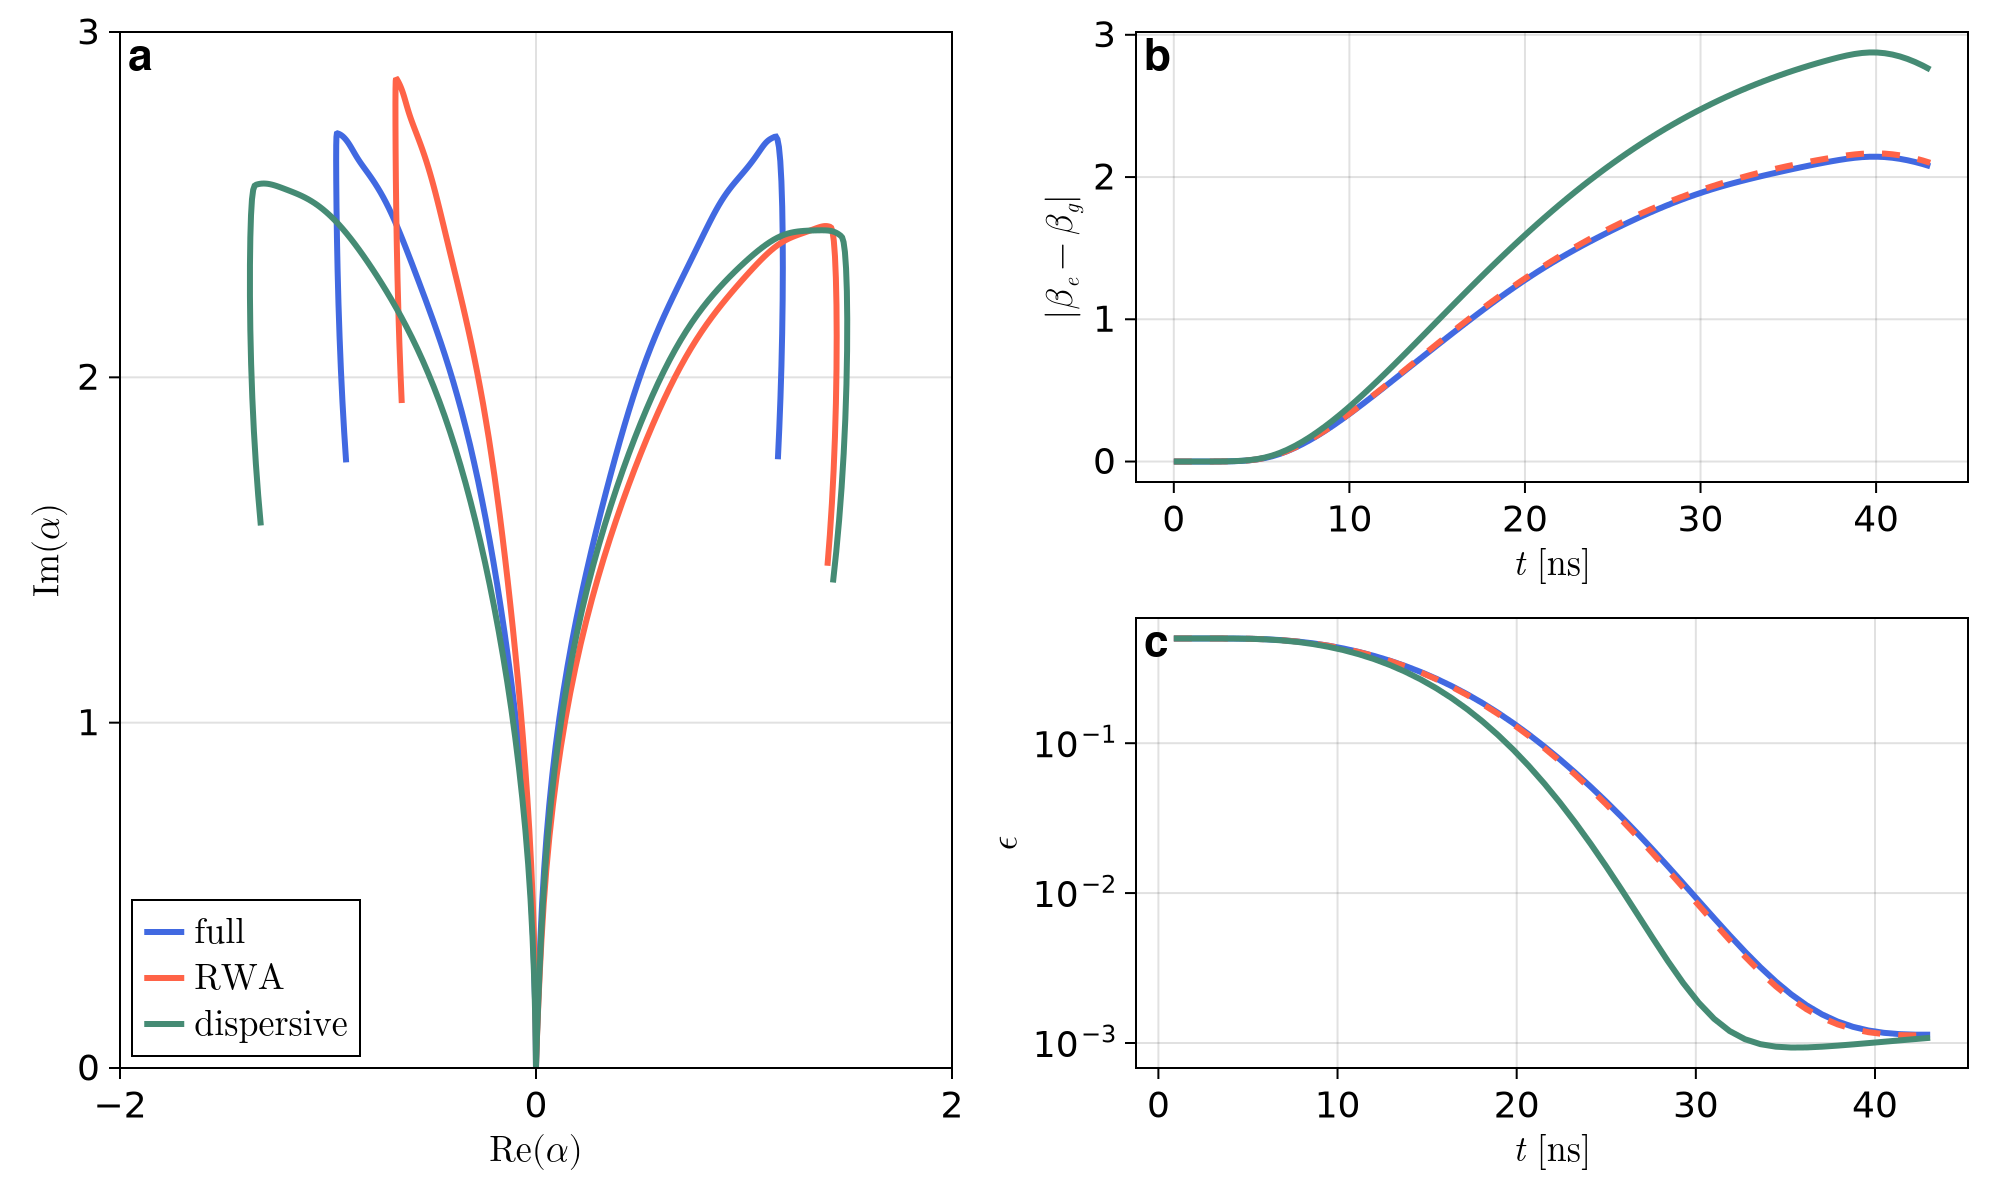

In [10]:
fig = Figure(size =(1000,600),fontsize = 18 ,fonts = (; regular = "Dejavu", weird = font_path))
ax1 = Axis(fig[1:2,1],xticks = [-2,0,2],yticks = [0,1,2,3],xlabel = L"Re($\alpha$)",ylabel = L"Im($\alpha$)")

lines!(real.(expect(a,states0)),imag.(expect(a,states0)),linewidth = 3, color = :royalblue,label = L"$$full")
lines!(real.(expect(a,states1)),imag.(expect(a,states1)),linewidth = 3, color = :royalblue)
lines!(real.(expect(a,states0_rwa)),imag.(expect(a,states0_rwa)),linewidth = 3, color = :tomato,label = L"$$RWA")
lines!(real.(expect(a,states1_rwa)),imag.(expect(a,states1_rwa)),linewidth = 3, color = :tomato)
lines!(real.(expect(a,states0_disp)),imag.(expect(a,states0_disp)),linewidth = 3, color = :aquamarine4,label = L"$$dispersive")
lines!(real.(expect(a,states1_disp)),imag.(expect(a,states1_disp)),linewidth = 3, color = :aquamarine4)

xlims!(-2,2)
ylims!(0,3)
axislegend(position = :lb)

ax2 = Axis(fig[1,2],xlabel =L"$t$ [ns]",ylabel = L"|\beta_e-\beta_g|")
lines!(tlist,abs.((expect(a,states1)).-(expect(a,states0))),linewidth = 3.0,color = :royalblue,label = L"$$full")
lines!(tlist,abs.((expect(a,states1_rwa)).-(expect(a,states0_rwa))),linewidth = 3.0,color = :tomato,linestyle = :dash,label = L"$$RWA")
lines!(tlist,abs.((expect(a,states1_disp)).-(expect(a,states0_disp))),linewidth = 3.0,color = :aquamarine4,label = L"$$dispersive")
# axislegend(position = :lt)

ax3 = Axis(fig[2,2],yscale = log10,ylabel = L"$\epsilon$",xlabel =L"$t$ [ns]")
lines!(tlist[3:2:end],(k_qubit/2).*tlist[3:2:end].+0.5*erfc.(SNR/2),linewidth = 3.0,label = L"$\epsilon_{full}$",color = :royalblue)
lines!(tlist[3:2:end],(k_qubit/2).*tlist[3:2:end].+0.5*erfc.(SNR_rwa/2),linewidth = 3.0,label = L"$\epsilon_{RWA}$",color = :tomato,linestyle = :dash)
lines!(tlist[3:2:end],(k_qubit/2).*tlist[3:2:end].+0.5*erfc.(SNR_disp/2),linewidth = 3.0,label = L"$\epsilon_{disp}$",color = :aquamarine4)

# axislegend(position = :rt)


text!(
        ax1, 0, 1,
        text = "a",
        align = (:left, :top),
        offset = (4, -2),
        space = :relative,
        fontsize = 22,
        font = :weird
)

text!(
        ax2, 0, 1,
        text = "b",
        align = (:left, :top),
        offset = (4, -2),
        space = :relative,
        fontsize = 22,
        font = :weird
)

text!(
        ax3, 0, 1,
        text = "c",
        align = (:left, :top),
        offset = (4, -2),
        space = :relative,
        fontsize = 22,
        font = :weird
)


save("figures/figures_thesis/minimzation_comparison.svg",format = "svg",fig)
fig

# Limitations

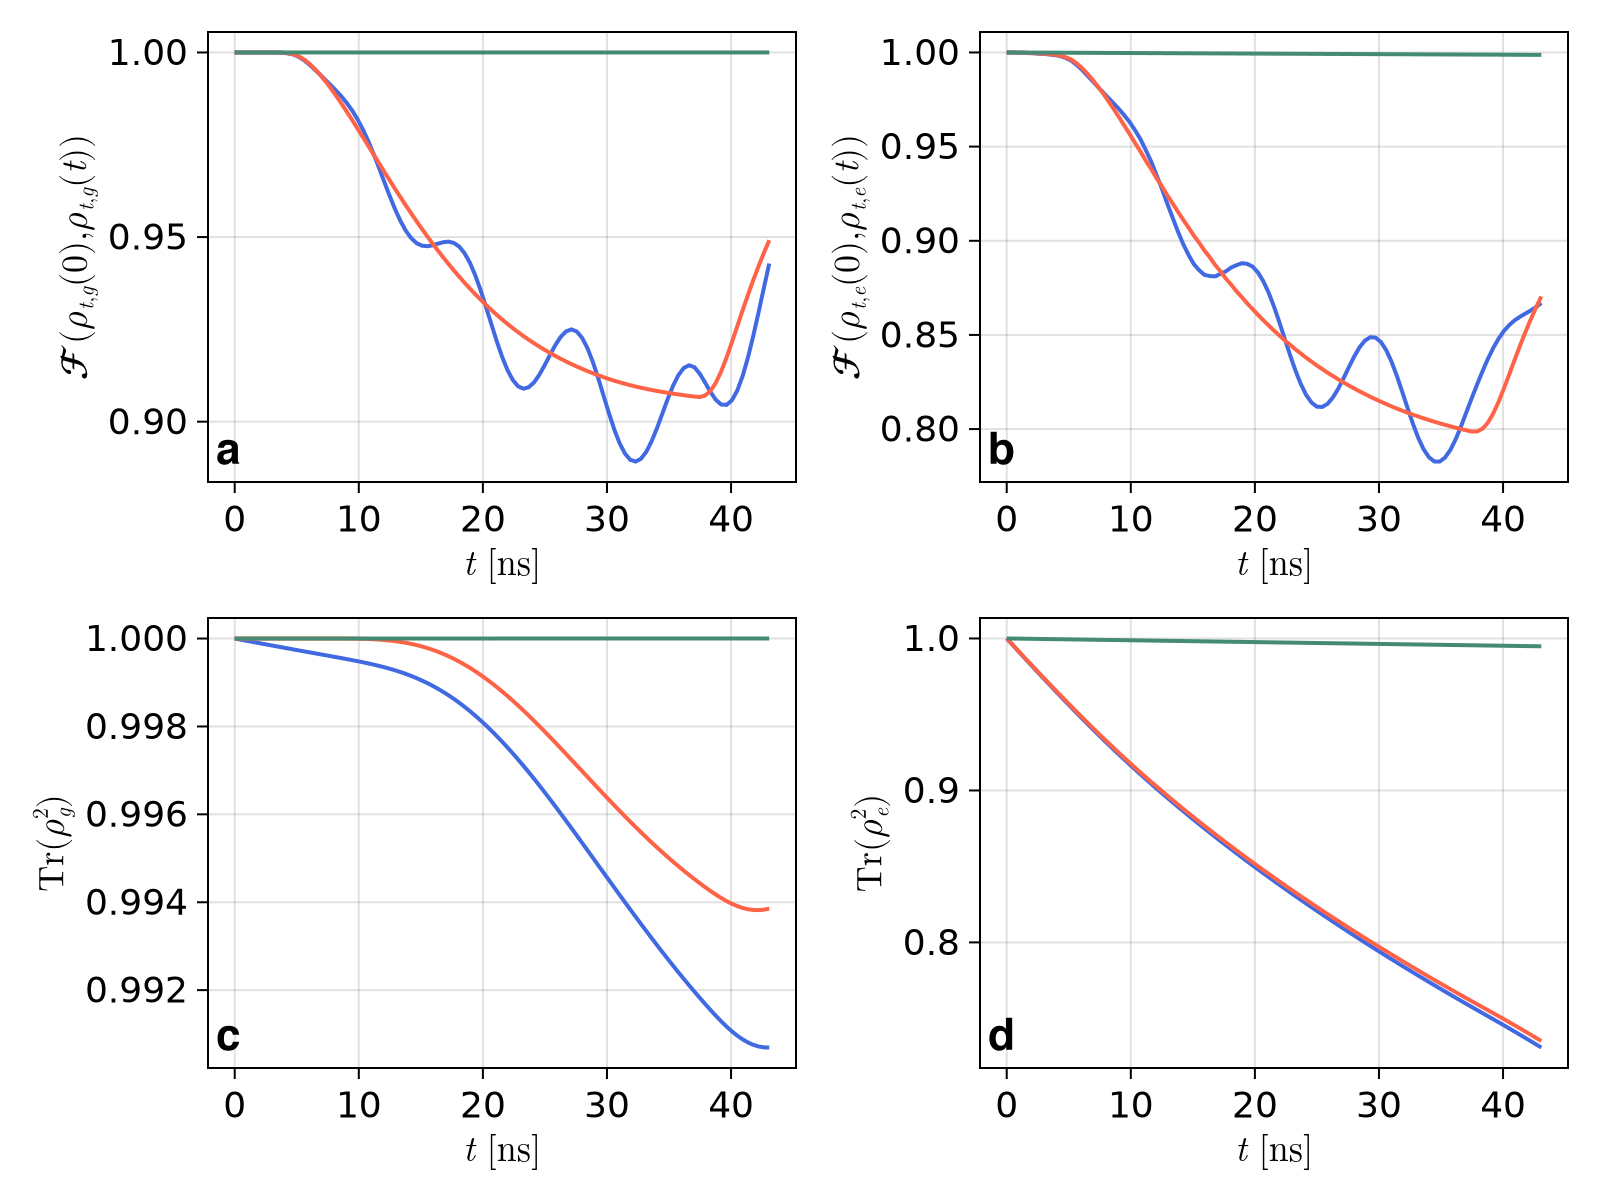

In [52]:

fig = Figure(size = (800,600), fontsize = 18 ,fonts = (; regular = "Dejavu", weird = font_path))
ax1 =Axis(fig[1,1],xlabel = L"$t$ [ns]", ylabel = L"$\mathcal{F}(\rho_{t,g}(0),\rho_{t,g}(t))$")
lines!(tlist,[fidelity(ptrace(states0[1],2),ptrace(s,2)) for s in states0],linewidth = 2.0,color = :royalblue)
lines!(tlist,[fidelity(ptrace(states0_rwa[1],2),ptrace(s,2)) for s in states0_rwa],linewidth = 2.0,color = :tomato)
lines!(tlist,[fidelity(ptrace(states0_disp[1],2),ptrace(s,2)) for s in states0_disp],linewidth = 2.0,color = :aquamarine4)



ax2 =Axis(fig[1,2],xlabel = L"$t$ [ns]", ylabel = L"$\mathcal{F}(\rho_{t,e}(0),\rho_{t,e}(t))$")
lines!(tlist,[fidelity(ptrace(states1[1],2),ptrace(s,2)) for s in states1],linewidth = 2.0,color = :royalblue)
lines!(tlist,[fidelity(ptrace(states1_rwa[1],2),ptrace(s,2)) for s in states1_rwa],linewidth = 2.0,color = :tomato)
lines!(tlist,[fidelity(ptrace(states1_disp[1],2),ptrace(s,2)) for s in states1_disp],linewidth = 2.0,color = :aquamarine4)

ax3 = Axis(fig[2,1],xlabel = L"$t$ [ns]",ylabel  = L"Tr($\rho_g^2$)")
lines!(tlist,real.(tr.(states0.*states0)),linewidth = 2.0,color = :royalblue)
lines!(tlist,real.(tr.(states0_rwa.*states0_rwa)),linewidth = 2.0,color = :tomato)
lines!(tlist,real.(tr.(states0_disp.*states0_disp)),linewidth = 2.0,color = :aquamarine4)

ax4 = Axis(fig[2,2],xlabel = L"$t$ [ns]",ylabel  = L"Tr($\rho_e^2$)")
lines!(tlist,real.(tr.(states1.*states1)),linewidth = 2.0,color = :royalblue)
lines!(tlist,real.(tr.(states1_rwa.*states1_rwa)),linewidth = 2.0,color = :tomato)
lines!(tlist,real.(tr.(states1_disp.*states1_disp)),linewidth = 2.0,color = :aquamarine4)



text!(
        ax1, 0.0, 0.125,
        text = "a",
        align = (:left, :top),
        offset = (4, -2),
        space = :relative,
        fontsize = 22,
        font = :weird
)
text!(
        ax2, 0.0, 0.125,
        text = "b",
        align = (:left, :top),
        offset = (4, -2),
        space = :relative,
        fontsize = 22,
        font = :weird
)
text!(
        ax3, 0.0, 0.125,
        text = "c",
        align = (:left, :top),
        offset = (4, -2),
        space = :relative,
        fontsize = 22,
        font = :weird
)
text!(
        ax4, 0.0, 0.125,
        text = "d",
        align = (:left, :top),
        offset = (4, -2),
        space = :relative,
        fontsize = 22,
        font = :weird
)


save("figures/figures_thesis/limitations.svg",format = "svg",fig)
fig


# Robustness

In [237]:
f = load("data/mapping_ec_ej_2025-01-20T17:55:20.095.jld2")
ej_set = f["ej_set"];
ec_set = f["ec_set"];
results = f["results"];

In [238]:
nsimux = length(results[:,1])
nsimuy = length(results[1,:])

SNR = zeros((25,25))
photons = zeros((25,25))
T1 = results[1,1][end]
for i in 1:nsimux
    for j in 1:nsimuy

        SNR[i,j] = results[i,j][1]
        photons[i,j]= results[i,j][2]

    end
end

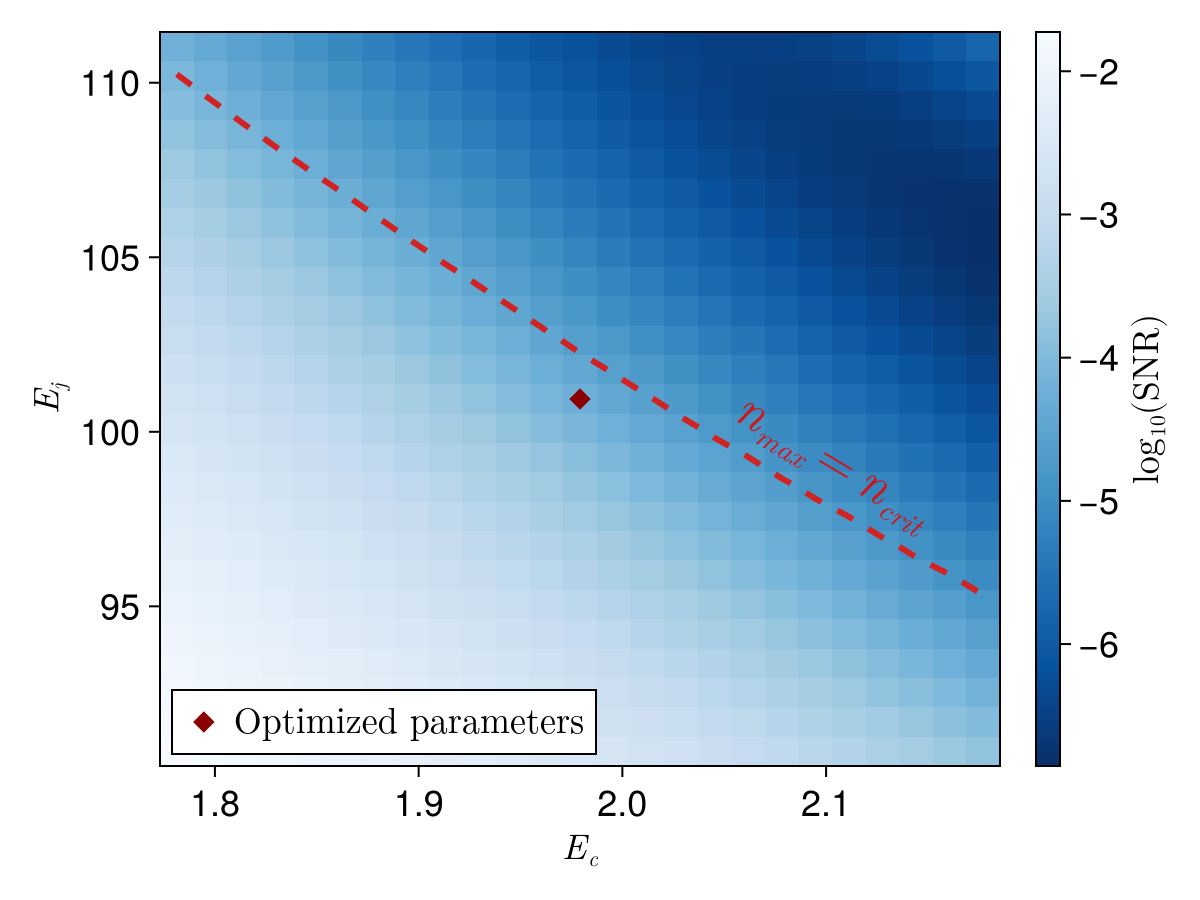

In [239]:
fig = Figure(fontsize = 18)
ax = Axis(fig[1,1],xlabel = L"E_c",ylabel = L"E_j")
hm = heatmap!(ax, ec_set, ej_set, log10.(SNR),colormap =reverse(to_colormap(:Blues)))
scatter!(ax, [ec], [ej], color = :red4,marker = :diamond,markersize = 12.0,label = L"$$Optimized parameters")
contour!( ec_set, ej_set, (photons), levels = 0.015:0.01:0.016,linewidth = 3.0,linestyle = :dash,colormap = reverse(to_colormap(:Reds_4)))
text!(2.05, 100, text = L"$n_{max} = n_{crit}$", color = to_colormap(:Reds_4)[end],rotation =-pi/4+0.25,fontsize = 25)
cb = Colorbar(fig[1, 2], hm,label = L"$\log_{10}$(SNR)")
axislegend(position = :lb)
save("figures/figures_thesis/robustness_ec_ej_map.svg",format = "svg",fig)
fig